In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division



import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np

import os
import warnings

# Dependency imports
from absl import app
from absl import flags
import matplotlib
matplotlib.use('Agg')
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg



from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,Layer
from tensorflow.keras.layers import Lambda, Concatenate, BatchNormalization, Activation, ZeroPadding2D,LeakyReLU,UpSampling2D, Conv2D,Add, LayerNormalization
from tensorflow.keras.layers import Cropping2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from functools import partial

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import sys

from random import choice

import pdb



In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
tf.enable_v2_behavior()


## This code restricts GPU usage

In [5]:

gpus = tf.config.experimental.list_physical_devices('GPU')


if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 7)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [6]:
bs=128
class RandomWeightedAverage(Add):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((bs, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [7]:
tfd = tfp.distributions

IMAGE_SHAPE = [28, 28, 1]
NUM_TRAIN_EXAMPLES = 60000
NUM_HELDOUT_EXAMPLES = 10000
NUM_CLASSES = 10

In [8]:
class MNISTSequence(tf.keras.utils.Sequence):
  """Produces a sequence of MNIST digits with labels."""

  def __init__(self, data=None, batch_size=128, fake_data_size=None):
    """Initializes the sequence.

    Args:
      data: Tuple of numpy `array` instances, the first representing images and
            the second labels.
      batch_size: Integer, number of elements in each training batch.
      fake_data_size: Optional integer number of fake datapoints to generate.
    """
    if data:
      images, labels = data
    else:
      images, labels = MNISTSequence.__generate_fake_data(
          num_images=fake_data_size, num_classes=NUM_CLASSES)
    self.images, self.labels = MNISTSequence.__preprocessing(
        images, labels)
    self.batch_size = batch_size

  @staticmethod
  def __generate_fake_data(num_images, num_classes):
    """Generates fake data in the shape of the MNIST dataset for unittest.

    Args:
      num_images: Integer, the number of fake images to be generated.
      num_classes: Integer, the number of classes to be generate.
    Returns:
      images: Numpy `array` representing the fake image data. The
              shape of the array will be (num_images, 28, 28).
      labels: Numpy `array` of integers, where each entry will be
              assigned a unique integer.
    """
    images = np.random.randint(low=0, high=256,
                               size=(num_images, IMAGE_SHAPE[0],
                                     IMAGE_SHAPE[1]))
    labels = np.random.randint(low=0, high=num_classes,
                               size=num_images)
    return images, labels

  @staticmethod
  def __preprocessing(images, labels):
    """Preprocesses image and labels data.

    Args:
      images: Numpy `array` representing the image data.
      labels: Numpy `array` representing the labels data (range 0-9).

    Returns:
      images: Numpy `array` representing the image data, normalized
              and expanded for convolutional network input.
      labels: Numpy `array` representing the labels data (range 0-9),
              as one-hot (categorical) values.
    """
    #images = 2 * (images / 255.) - 1.
    images = images[..., tf.newaxis]

    labels = tf.keras.utils.to_categorical(labels)
    return images, labels

  def __len__(self):
    return int(tf.math.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, idx):
    batch_x = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
    return batch_x, batch_y


In [9]:

class GWINGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.img_total = self.img_rows*self.img_cols*self.channels
        self.latent_dim = 100
        self.batch_size = 128
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
        optimizer2 = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
        # Build the generator and critic

        self.classifier = self.build_classifier()
        
        # Construct graph for classifier
        img = Input(shape=self.img_shape)
        classification = self.classifier(img)
        self.classifier_model = Model(img, classification, name="classifier_model") # input/output
        
        classifier_optimizer = tf.keras.optimizers.Adam(lr=0.001)
        self.classifier_model.compile(optimizer=classifier_optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)
        # we pass in y on our own. y_true i mean.
        self.classifier_model.summary()
        
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        #self.critic.trainable = False
        #self.generator.trainable = True
        #self.classifier.trainable = False
        
        self.generator = self.build_generator()
        self.critic = self.build_critic2()
        
        for layer in self.classifier.layers:
            layer.trainable = False
        for layer in self.critic.layers:
            layer.trainable = False
        for layer in self.generator.layers:
            layer.trainable = True
        
        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        real_img = Input(shape=self.img_shape)
        og_img = K.reshape(real_img, shape=(-1, self.img_total))
        label = Input(shape=(self.classes,))
        # Generate images based of noise
        # this is functional
        # also get your img.
        concat = K.concatenate([z_gen, og_img])
        img = self.generator(concat)
        # Discriminator determines validity
        valid = self.critic((img, label))
        classify = self.classifier(img)
        # Defines generator model
        self.generator_model = Model(inputs=[z_gen, real_img, label], outputs=[valid, classify], name="generator_model")
        # where even is the y_true happening? for our loss functions
        self.generator_model.compile(loss=[self.wasserstein_loss, 
                                            self.transformation_penalty_loss], 
                                     optimizer=optimizer,
                                     loss_weights=[1, 10])
        self.generator_model.summary()
        
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------
        
        #self.critic.trainable = True
        #self.generator.trainable = False
        #self.classifier.trainable = False
        
                
        for layer in self.critic.layers:
            layer.trainable = True
            
        for layer in self.generator.layers:
            layer.trainable = False
            

        # also want class here
        
        # Image input (real sample)
        real_img = Input(shape=self.img_shape)
        og_img = K.reshape(real_img, shape=(-1, self.img_total))
        
        
        # -1 means ALL in a shape 
 
        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        concat = K.concatenate([z_disc, og_img])
        # Generate image based of noise (fake sample)
        label = Input(shape=(self.classes,))
        # Generate images based of noise
        # this is functional
        # also get your img.
        
        fake_img = self.generator(concat)
#        pdb.set_trace()
        # Discriminator determines validity of the real and fake images
        fake = self.critic((fake_img, label))
        valid = self.critic((real_img, label))

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic((interpolated_img, label))

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        self.partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        self.partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc, label],
                            outputs=[valid, fake, validity_interpolated], name="critic_model")
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              self.partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        self.critic_model.summary()

        
        
    def transformation_penalty_loss(self, y_true, y_pred):
        return K.categorical_crossentropy(y_true, y_pred)

    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        try:
          gradients_sqr = K.square(gradients)
        except ValueError:
          print("Error")
          return 0
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_classifier(self):
        kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        model = tf.keras.models.Sequential([
          tfp.layers.Convolution2DFlipout(
              6, kernel_size=5, padding='SAME',
              kernel_divergence_fn=kl_divergence_function,
              activation=tf.nn.relu),
          tf.keras.layers.MaxPooling2D(
              pool_size=[2, 2], strides=[2, 2],
              padding='SAME'),
          tfp.layers.Convolution2DFlipout(
              16, kernel_size=5, padding='SAME',
              kernel_divergence_fn=kl_divergence_function,
              activation=tf.nn.relu),
          tf.keras.layers.MaxPooling2D(
              pool_size=[2, 2], strides=[2, 2],
              padding='SAME'),
          tfp.layers.Convolution2DFlipout(
              120, kernel_size=5, padding='SAME',
              kernel_divergence_fn=kl_divergence_function,
              activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          tfp.layers.DenseFlipout(
              84, kernel_divergence_fn=kl_divergence_function,
              activation=tf.nn.relu),
          tfp.layers.DenseFlipout(
              NUM_CLASSES, kernel_divergence_fn=kl_divergence_function,
              activation=tf.nn.softmax)
      ])
        #model.build()
        #model.summary()
        img = Input(shape=self.img_shape)
        classification = model(img)
        return Model(img, classification, name="classifier")
    # Do we ned to remove norm 
    def build_generator(self):

        model = Sequential()
        model.add(Dense(4*4*256, activation="relu", input_dim=self.latent_dim + self.img_total))
        model.add(Reshape((4, 4, 256)))
        model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"))
        #model.add(UpSampling2D(4))
        #model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Cropping2D(cropping=((0, 1), (0, 1))))
        
        model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"))
        #model.add(UpSampling2D(4))
        #model.add(Conv2D(64, kernel_size=5, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(self.channels, kernel_size=5, strides=2, padding="same"))
        #model.add(UpSampling2D(4))
        #model.add(Conv2D(self.channels, kernel_size=5, strides=2, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        concat = Input(shape=(self.latent_dim + self.img_total,))
        img = model(concat)

        return Model(concat, img, name="generator")

    
    def build_critic2(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(self.classes,))
        label_reshaped = K.reshape(label, shape=(-1, 1, 1, self.classes))
        
        #tiled = K.tile(a, [4, 4, 1])
        tiled = K.tile(label_reshaped, [1, 28, 28, 1])
        concat = K.concatenate([img, tiled], axis=3)
        
        
        x = Conv2D(64, kernel_size=5, strides=2, padding="same")(concat)
        x = LayerNormalization(epsilon = 1e-6)(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        tiled = K.tile(label_reshaped, [1, 14, 14, 1])
        concat = K.concatenate([x, tiled], axis=3)
        
        x = Conv2D(128, kernel_size=5, strides=2, padding="same")(concat)
        x = LayerNormalization(epsilon = 1e-6)(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        tiled = K.tile(label_reshaped, [1, 7, 7, 1])
        concat = K.concatenate([x, tiled], axis=3)
        
        x = Conv2D(256, kernel_size=5, strides=2, padding="same")(concat)
        x = LayerNormalization(epsilon = 1e-6)(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        tiled = K.tile(label_reshaped, [1, 4, 4, 1])
        concat = K.concatenate([x, tiled], axis=3)
        

        x = Flatten()(concat)
        
        validity = Dense(1)(x)
        #pdb.set_trace()
        return Model(inputs=[img, label], outputs=[validity], name="critic")
    
    def train_classifier(self, epochs, batch_size, dataset):
        
        train_X, train_y = dataset
        
        #train_X = (train_X.astype(np.float32) - 127.5) / 127.5
        
        train_set = (train_X, train_y)
        train_seq = MNISTSequence(data=train_set, batch_size=batch_size)

        
        for epoch in range(epochs):
            epoch_accuracy, epoch_loss = [], []
        
            for step, (batch_x, batch_y) in enumerate(train_seq):
                batch_loss, batch_accuracy = self.classifier_model.train_on_batch(batch_x, batch_y)
                epoch_loss.append(batch_loss)
                epoch_accuracy.append(batch_accuracy)
            print("Epoch", epoch, "Accuracy", np.average(epoch_accuracy), "Loss", np.average(epoch_loss)) 

    def train(self, epochs, batch_size, full_data, confident_data, sample_interval=50):

        # Load the dataset
        (X_train, y_train) = full_data
        (confident_X_train, confident_y_train) = confident_data

        # Rescale -1 to 1
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        
        #confident_X_train = (confident_X_train.astype(np.float32) - 127.5) / 127.5
        confident_X_train = np.expand_dims(confident_X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        
        for epoch in range(epochs):
            self.critic.trainable = True
            self.generator.trainable= False
            self.classifier.trainable = False
            """
            model = self.generator_model
            trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
            not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
            print(trainable_count, not_trainable_count)
            model = self.critic_model
            trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
            not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
            print(trainable_count, not_trainable_count)
            """
            for _ in range(self.n_critic):
                
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # only train on confident images! 
                # One-hot encode the guys
                # Select a random batch of images
                idx = np.random.randint(0, confident_X_train.shape[0], batch_size)
                imgs = confident_X_train[idx]
                labels = confident_y_train[idx]
                one_hot_labels = tf.keras.utils.to_categorical(labels)
                #labels = np.expand_dims(labels, axis=2)
                
                # random batch rather than going line by ine? 
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                #pdb.set_trace()
                # Train the critic
                
                
                
                d_loss = self.critic_model.train_on_batch([imgs, noise, one_hot_labels],
                                                                [valid, fake, dummy])
                

            # ---------------------
            #  Train Generator
            # ---------------------
            # train on all images 
            self.critic.trainable = False
            self.generator.trainable = True
            self.classifier.trainable = False
            """
            model = self.generator_model
            trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
            not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
            print(trainable_count, not_trainable_count)
            model = self.critic_model
            trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
            not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
            print(trainable_count, not_trainable_count)
            """
            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]
            one_hot_labels = tf.keras.utils.to_categorical(labels)
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            
            
            g_loss = self.generator_model.train_on_batch([noise,imgs,one_hot_labels], [valid, one_hot_labels])
            
            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f % f]" % (epoch, d_loss[0], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                img = imgs[:25]
                self.sample_images(epoch, img)
                
            # save model at interval
            
            if epoch % 10000 == 0:
                self.critic_model.save('critic_model_2_' + str(epoch))
                self.generator_model.save('generator_model_2_' + str(epoch))

                

    def sample_images(self, epoch, img):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        og_img = K.reshape(img, shape=(-1, self.img_total))
        #pdb.set_trace()
        concat = K.concatenate([noise, og_img], axis=1)
        gen_imgs = self.generator.predict(concat)
        
        

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [10]:
gwin = GWINGP()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
classifier (Model)           (None, 10)                1090856   
Total params: 1,090,856
Trainable params: 1,090,856
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              3624960   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_tran

In [11]:
# if load model
gwin.classifier_model = tf.keras.models.load_model('classifier_model4')

## Confirm trainable params matches and layers are frozen

In [38]:

model = gwin.generator_model
#model.layers[4].trainable = True
#model.layers[6].trainable = False
gwin.generator.trainable = True
gwin.classifier.trainable = False
gwin.critic.trainable = False
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
print(trainable_count, not_trainable_count)
model.summary()

model = gwin.critic_model
#model.layers[4].trainable = False
#model.layers[7].trainable = True
gwin.critic.trainable = True
gwin.generator.trainable = False
gwin.classifier.trainable = False
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
not_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
print(trainable_count, not_trainable_count)
model.summary()

4651137 2234441
Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape_8 (TensorFl [(None, 784)]        0           input_29[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_concat_16 (TensorFl [(None, 884)]        0           input_28[0][0]                   
                                                                 tf_

## Load dataset

In [12]:
train_set, test_set = mnist.load_data()
train_X, train_y = train_set
test_X, test_y = test_set
test_y_label = tf.keras.utils.to_categorical(test_y)
train_y_label = tf.keras.utils.to_categorical(train_y)

## Scale to (-1, 1)

In [13]:
# scaled data
# float32, normalize
# You can try normalize and minmax-scaling. Normalize(0, 1) and min-max(0, 1)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler((-1, 1))
scaler2 = MinMaxScaler((-1, 1))
train_X = train_X.astype(np.float32)
train_X = np.reshape(train_X, (len(train_X), -1))
train_X = scaler.fit_transform(train_X)
test_X = test_X.astype(np.float32)
test_X = np.reshape(test_X, (len(test_X), -1))
test_X = scaler2.fit_transform(test_X)
train_X = np.reshape(train_X, (len(train_X), 28, 28))
test_X = np.reshape(test_X, (len(test_X), 28, 28))

scaled_train_set = (train_X, train_y)
scaled_test_set = (test_X, test_y)

## Train classifier

In [94]:
gwin.classifier.trainable = True
gwin.train_classifier(30, 128, scaled_train_set) # paper has 30, 128
# save model if possible here also! 
# shuffle the data when training!

Epoch 0 Accuracy 0.726656894058561 Loss 22.80905271745694
Epoch 1 Accuracy 0.947228144989339 Loss 19.79784492948162
Epoch 2 Accuracy 0.9635916400565776 Loss 17.276507953082575
Epoch 3 Accuracy 0.9718705579670254 Loss 14.81550467192237
Epoch 4 Accuracy 0.9754741914999256 Loss 12.515697383677272
Epoch 5 Accuracy 0.9769234185788169 Loss 10.45877138841381
Epoch 6 Accuracy 0.978267146453166 Loss 8.708938282435891
Epoch 7 Accuracy 0.9797830046621213 Loss 7.268296133988956
Epoch 8 Accuracy 0.9802993959201171 Loss 6.119022515791057
Epoch 9 Accuracy 0.9808713130351069 Loss 5.219498112765965
Epoch 10 Accuracy 0.9812877575980067 Loss 4.519127425862782
Epoch 11 Accuracy 0.98252043350419 Loss 3.972051710462265
Epoch 12 Accuracy 0.9822094882729211 Loss 3.539312298109791
Epoch 13 Accuracy 0.982464907647196 Loss 3.186181178225129
Epoch 14 Accuracy 0.9829868514146378 Loss 2.8921985971902227
Epoch 15 Accuracy 0.9827536424594139 Loss 2.64668165442786
Epoch 16 Accuracy 0.9838252931769723 Loss 2.4334899850

In [97]:
# Save classifier if needed
#gwin.classifier_model.save('classifier_model4')

## Confirm classifier results

In [22]:
results = gwin.classifier_model.evaluate(train_X, train_y_label, batch_size=64)


938/938 [==============================] - 3s 3ms/step - loss: 1.0108 - accuracy: 0.9828


In [122]:
results = gwin.classifier_model.evaluate(test_X, test_y_label, batch_size=64)


157/157 [==============================] - 1s 5ms/step - loss: 0.0628 - accuracy: 0.9822


In [15]:
train_set, heldout_set = tf.keras.datasets.mnist.load_data()
train_seq = MNISTSequence(data=train_set, batch_size=128)
scaled_train_seq = MNISTSequence(data=scaled_train_set, batch_size=128)
heldout_seq = MNISTSequence(data=heldout_set, batch_size=128)
scaled_test_seq = MNISTSequence(data=scaled_test_set, batch_size=128)


## Define methods to quantify uncertainty

In [16]:
monte_carlo_count = 10 # how many monte carlo samples?
def classify_samples(seq=None, samples=None):
    if seq:
        probs = tf.stack([gwin.classifier_model.predict(seq, verbose=1) for _ in range(monte_carlo_count)])
    else:
        samples_reshape = np.reshape(samples, (len(samples), 28, 28, 1))
        probs = [gwin.classifier_model.predict(samples_reshape, verbose=1) for _ in range(monte_carlo_count)]
    # probs dimensions is monte_carlo_count x class x sample
    mean_probs = tf.reduce_mean(probs, axis=0) # average monte carlo samples to class probs x sample
    prediction_probs = tf.argmax(mean_probs, axis=1) # take the arg_max of the mean class probs as prediction
    # we take the median as stated in paper for the certainty                      
    certainty_probs = tfp.stats.percentile(probs, 50.0, axis=0, interpolation='midpoint')
    certainty_prediction_probs = [j[prediction_probs[i]] for i, j in enumerate(certainty_probs)] # the median certainty of the argmax prediction class
    return mean_probs, prediction_probs, certainty_prediction_probs
    

In [32]:
# rewrite to take indices instead
def get_certain_uncertain_data(rejection_threshold, certainty_prediction_probs):
    certainty_prediction_probs = np.array(certainty_prediction_probs)
    rejection_indices = np.where(certainty_prediction_probs < rejection_threshold)[0]
    confident_indices = np.where(certainty_prediction_probs >= rejection_threshold)[0]
    return rejection_indices, confident_indices 


In [21]:
mean_probs, prediction_probs, certainty_prediction_probs = classify_samples(scaled_train_set, scaled_train_seq)


1875/1875 [==============================] - 6s 3ms/step


In [30]:
np.array(certainty_prediction_probs)

array([0.9999841 , 0.99999964, 0.99999857, ..., 0.9999999 , 0.99998635,
       0.99996203], dtype=float32)

In [34]:
rejection_indices, confident_indices = get_certain_uncertain_data(0.99, certainty_prediction_probs)
confident_train_data = (scaled_train_set[0][confident_indices], scaled_train_set[1][confident_indices])
rejection_train_data = (scaled_train_set[0][rejection_indices], scaled_train_set[1][rejection_indices])


In [35]:
len(confident_train_data[0])

55702

In [36]:
len(rejection_train_data[0])

4298

In [34]:
np.shape(train_set[0])

(60000, 28, 28)

In [37]:
# takes about 16666 per hour
gwin.train(11, 128, scaled_train_set[:2], confident_train_data[:2])
# move to 200000, 128


Error
Error
0 [D loss: -12.798713] [G loss: 63.801403  3.364523]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: critic_model_2_0/assets
INFO:tensorflow:Assets written to: generator_model_2_0/assets
1 [D loss: -36.331383] [G loss: 67.557320  12.783488]
2 [D loss: -54.455017] [G loss: 72.766434  17.413059]
3 [D loss: -66.120636] [G loss: 72.128998  15.613409]
4 [D loss: -75.901306] [G loss: 68.912827  10.104902]
5 [D loss: -84.325630] [G loss: 60.550648  5.779445]
6 [D loss: -90.859406] [G loss: 54.439445  1.223734]
7 [D loss: -97.097092] [G loss: 56.857170  0.601704]
8 [D loss: -102.238571] [G loss: 53.323627 -0.261549]
9 [D loss: -106.370773] [G loss: 54.855171 -0.373631]
10 [D loss: -109.988403] [G loss: 58.849911  4.710323]


In [190]:
# for loading models
gwin.generator_model = tf.keras.models.load_model('generator_model_2_50000', custom_objects = {'wasserstein_loss': gwin.wasserstein_loss, 'transformation_penalty_loss': gwin.transformation_penalty_loss})

In [28]:
gwin.critic_model = tf.keras.models.load_model('critic_model_200000_1', custom_objects = {'wasserstein_loss': gwin.wasserstein_loss, 'gradient_penalty': gwin.partial_gp_loss})

In [39]:
# saving models
gwin.critic_model.save('critic_model_2')
gwin.generator_model.save('generator_model_2')


INFO:tensorflow:Assets written to: critic_model_2/assets
INFO:tensorflow:Assets written to: generator_model_2/assets


In [177]:
test_mean_probs, test_prediction_probs, test_certainty_prediction_probs = classify_samples(scaled_test_set, scaled_test_seq)
rejection_test_indices, confident_test_indices = get_certain_uncertain_data(0.5, test_certainty_prediction_probs)
confident_test_data_5 = (scaled_test_set[0][confident_test_indices], scaled_test_set[1][confident_test_indices])
rejection_test_data_5 = (scaled_test_set[0][rejection_test_indices], scaled_test_set[1][rejection_test_indices])


313/313 [==============================] - 1s 3ms/step


In [178]:
len(rejection_test_data[0])

47

In [191]:
# run this if you are loading pre-trained model
temp_generator = gwin.generator_model.layers[4]
gwin.generator.trainable = False

## Rejected data

In [201]:
num_rejections = len(rejection_test_data[0])
img = rejection_test_data[0][:num_rejections]

noise = np.random.normal(0, 1, (num_rejections, 100))
og_img = K.reshape(img, shape=(-1, 784))
concat = K.concatenate([noise, og_img], axis=1)

gen_imgs = temp_generator.predict(concat)
#gen_imgs = gwin.generator.predict(concat)  
gen_imgs = np.reshape(gen_imgs, (num_rejections, 28, 28))
true_probs, true_prediction, true_certainty = classify_samples(samples=img)
probs, prediction, certainty = classify_samples(samples=gen_imgs)
# re-predict each time!
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(true_probs, tf.keras.utils.to_categorical(rejection_test_data[1]))
print("Old Accuracy", m.result().numpy())

m2 = tf.keras.metrics.CategoricalAccuracy()
m2.update_state(probs, tf.keras.utils.to_categorical(rejection_test_data[1]))
print("New Accuracy", m2.result().numpy())




2/2 [==============================] - 0s 2ms/step
Old Accuracy 0.5531915
New Accuracy 0.4680851


In [139]:
true_certainty[:30]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.47216734>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.74490404>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9491377>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6124493>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6845535>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.60433835>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4521233>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.55566204>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.37761682>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6349215>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.69651836>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.50016564>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5969809>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7791>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47264695>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.56566274>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5282871>,
 <tf.Tensor: shape=(), dtype=float32, nump

## Plotting a few side by side samples

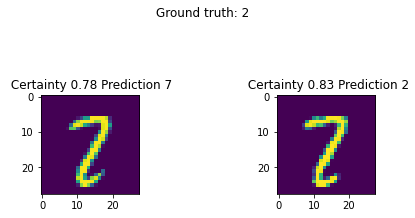

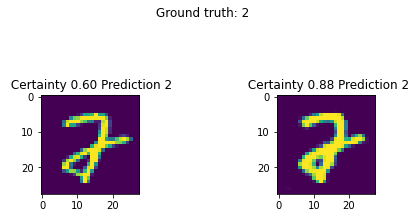

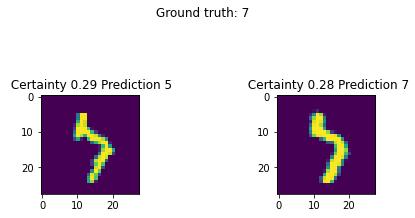

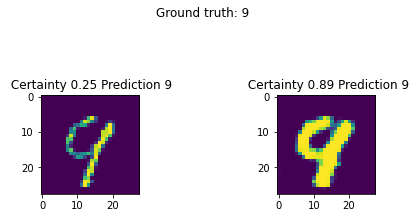

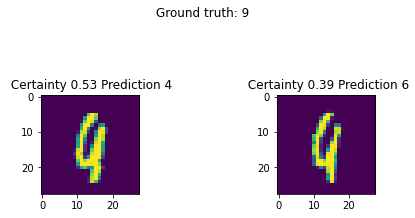

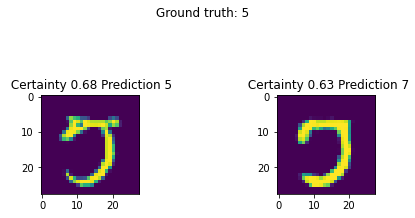

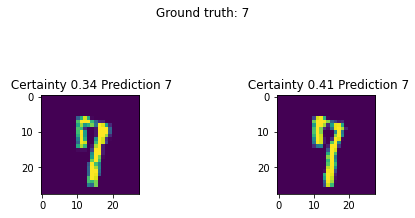

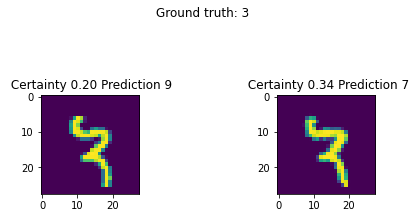

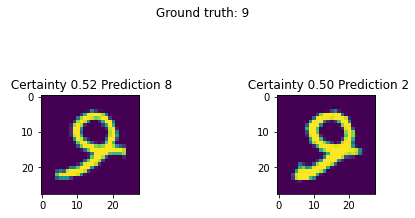

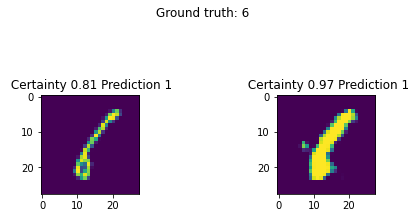

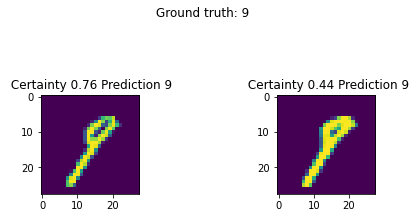

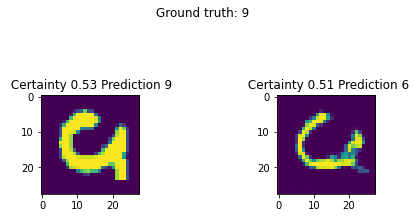

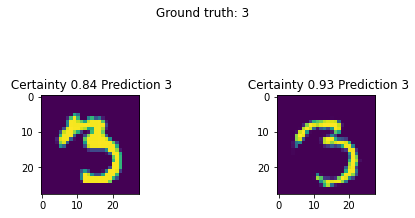

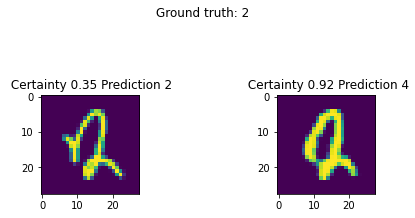

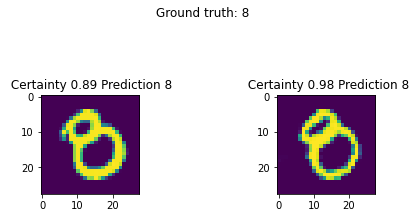

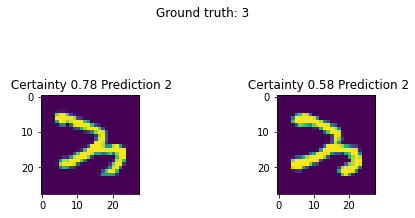

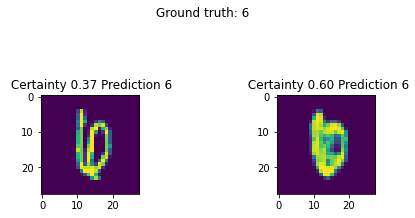

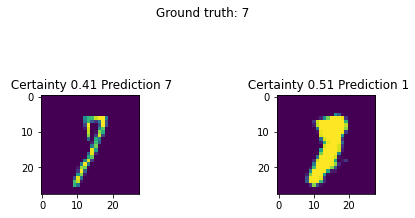

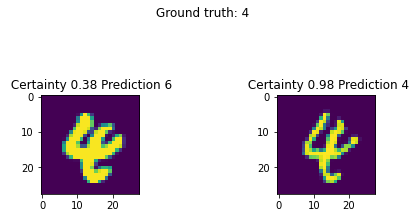

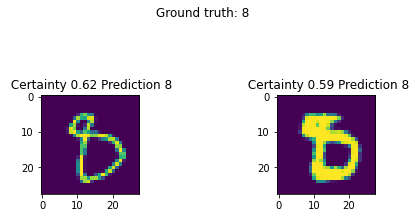

In [195]:
%matplotlib inline

for index in range(20):#num_rejections):
    plt.figure(index)
    #plt.tight_layout()
    plt.suptitle("Ground truth: " + str(rejection_test_data[1][index]))    
    
    plt.subplot(131)
    plt.title(" Certainty " + str(true_certainty[index].numpy())[:4] +  " Prediction " + str(true_prediction[index].numpy()))
    plt.imshow(img[index])


    
              
    plt.subplot(133)
    plt.title(" Certainty " + str(certainty[index].numpy())[:4] + " Prediction " + str(prediction[index].numpy()))
    # classify sample, get class and certainty
    plt.imshow(gen_imgs[index])

